In [ ]:
!pip install gym==0.26.2 gym[atari]==0.26.2 gym[accept-rom-license]==0.26.2 autorom ale-py
!pip install -U transformers bitsandbytes
!pip install -U accelerate
!pip install torch
!pip install seaborn
!pip install flash_attn

In [ ]:
!git clone https://huggingface.co/eloialonso/iris

fatal: destination path 'iris' already exists and is not an empty directory.


In [ ]:
import time
import os
import gc
import abc
import random
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from dataclasses import dataclass
from pathlib import Path
import warnings

from collections import deque
import math
from pathlib import Path
import random

import gym
from gym.wrappers import ResizeObservation
import torch
import torch.distributions as td
from torch.distributions import Normal, Categorical, OneHotCategorical, OneHotCategoricalStraightThrough
from torch.distributions.kl import kl_divergence
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, TrainingArguments, BitsAndBytesConfig, AutoModel, CLIPImageProcessor, AutoModelForCausalLM, AutoTokenizer


from typing import Any,Dict, List, Optional, Tuple, List, Union

import psutil
import sys

from einops import rearrange
from tqdm import tqdm
import wandb
import seaborn as sns
import traceback

In [ ]:
from configuration_iris import IrisConfig
from modeling_iris import IrisModel

In [ ]:
class RepeatAction(gym.Wrapper):
    """
    同じ行動を指定された回数自動的に繰り返すラッパー. 観測は最後の行動に対応するものになる
    """
    def __init__(self, env, skip=4, max_steps=100_000):
        gym.Wrapper.__init__(self, env)
        self.max_steps = max_steps if max_steps else float("inf")  # イテレーションの制限
        self.steps = 0  # イテレーション回数のカウント
        self.height = env.observation_space.shape[0]
        self.width = env.observation_space.shape[1]
        self._skip = skip

    def reset(self):
        obs = self.env.reset()
        return obs[0]

    def step(self, action):
        if self.steps >= self.max_steps:  # 100kに達したら何も返さないようにする
            print("Reached max iterations.")
            return None

        total_reward = 0.0
        self.steps += 1
        for _ in range(self._skip):
            obs, reward, done, _, info = self.env.step(action)

            total_reward += reward
            if self.steps >= self.max_steps:  # 100kに達したら終端にする
                done = True

            if done:
                break

        return obs, total_reward, done, info

In [ ]:
def make_env(id, seed=None, img_size=64, max_steps=100_000):
    env = gym.make(id)

    # シード固定
    env.seed(seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)

    env = ResizeObservation(env, (img_size, img_size))
    env = RepeatAction(env=env, skip=4, max_steps=max_steps)

    return env

In [ ]:
# モデルパラメータをGoogleDriveに保存・後で読み込みするためのヘルパークラス
class TrainedModels:
    def __init__(self, *models) -> None:
        """
        コンストラクタ．

        Parameters
        ----------
        models : nn.Module
            保存するモデル．複数モデルを渡すことができます．

        使用例: trained_models = TraindModels(encoder, rssm, value_model, action_model)
        """
        assert np.all([nn.Module in model.__class__.__bases__ for model in models]), "Arguments for TrainedModels need to be nn models."

        self.models = models

    def save(self, dir: str) -> None:
        """
        initで渡したモデルのパラメータを保存します．
        パラメータのファイル名は01.pt, 02.pt, ... のように連番になっています．

        Parameters
        ----------
        dir : str
            パラメータの保存先．
        """
        for i, model in enumerate(self.models):
            torch.save(
                model.state_dict(),
                os.path.join(dir, f"{str(i + 1).zfill(2)}.pt")
            )

    def load(self, dir: str, device: str) -> None:
        """
        initで渡したモデルのパラメータを読み込みます．

        Parameters
        ----------
        dir : str
            パラメータの保存先．
        device : str
            モデルをどのデバイス(CPU or GPU)に載せるかの設定．
        """
        for i, model in enumerate(self.models):
            model.load_state_dict(
                torch.load(
                    os.path.join(dir, f"{str(i + 1).zfill(2)}.pt"),
                    map_location=device
                )
            )

In [ ]:
def set_seed(seed: int) -> None:
    """
    Pytorch, NumPyのシード値を固定します．これによりモデル学習の再現性を担保できます．

    Parameters
    ----------
    seed : int
        シード値．
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
class ReplayBuffer(object):
    """
    RNNを用いて訓練するのに適したリプレイバッファ
    """
    def __init__(self, capacity, observation_shape, action_dim):
        self.capacity = capacity

        self.observations = np.zeros((capacity, *observation_shape), dtype=np.float32)
        self.actions = np.zeros((capacity, 1), dtype=np.uint8)
        self.rewards = np.zeros((capacity, 1), dtype=np.float32)
        self.done = np.zeros((capacity, 1), dtype=bool)

        self.index = 0
        self.is_filled = False

    def push(self, observation, action, reward, done):
        """
        リプレイバッファに経験を追加する
        """
        self.observations[self.index] = observation
        self.actions[self.index] = action
        self.rewards[self.index] = reward
        self.done[self.index] = done

        # indexは巡回し, 最も古い経験を上書きする
        if self.index == self.capacity - 1:
            self.is_filled = True
        self.index = (self.index + 1) % self.capacity

    def sample(self, batch_size, chunk_length):
        """
        経験をリプレイバッファからサンプルします. （ほぼ）一様なサンプルです
        結果として返ってくるのは観測(画像), 行動, 報酬, 終了シグナルについての(batch_size, chunk_length, 各要素の次元)の配列です
        各バッチは連続した経験になっています
        注意: chunk_lengthをあまり大きな値にすると問題が発生する場合があります
        """
        episode_borders = np.where(self.done)[0]
        sampled_indexes = []
        for _ in range(batch_size):
            cross_border = True
            while cross_border:
                initial_index = np.random.randint(len(self) - chunk_length + 1)
                final_index = initial_index + chunk_length - 1
                cross_border = np.logical_and(initial_index <= episode_borders,
                                              episode_borders < final_index).any()#論理積
            sampled_indexes += list(range(initial_index, final_index + 1))

        sampled_observations = self.observations[sampled_indexes].reshape(
            batch_size, chunk_length, *self.observations.shape[1:])
        sampled_actions = self.actions[sampled_indexes].reshape(
            batch_size, chunk_length, self.actions.shape[1])
        sampled_rewards = self.rewards[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        sampled_done = self.done[sampled_indexes].reshape(
            batch_size, chunk_length, 1)
        return sampled_observations, sampled_actions, sampled_rewards, sampled_done

    def __len__(self):
        return self.capacity if self.is_filled else self.index

    def save(self, dir: str):
        np.save(f"{dir}/observations", self.observations)
        np.save(f"{dir}/actions", self.actions)
        np.save(f"{dir}/rewards", self.rewards)
        np.save(f"{dir}/done", self.done)

    def load(self, dir: str):
        self.observations = np.load(f"{dir}/observations.npy")
        self.actions = np.load(f"{dir}/actions.npy")
        self.rewards = np.load(f"{dir}/rewards.npy")
        self.done = np.load(f"{dir}/done.npy")

In [ ]:
def build_projector(mm_hidden_size, hidden_size):
    return nn.Linear(mm_hidden_size, hidden_size).to(torch.bfloat16)

In [ ]:
class ProphetLM(nn.Module):

  def __init__(self,
               vision_tower,
               image_processor,
               llm,
               tokenizer):
    super().__init__()

    self.vision_tower = vision_tower
    self.image_processor = image_processor
    self.llm = llm
    self.tokenizer = tokenizer

    self.prompt_template = "[Current State]<current_image>[Next State (if {action})]<next_image> You can take follwing actions: {action_lists}. Is this a good action?"

    # self.vision_tower = AutoModel.from_pretrained(
    #           'OpenGVLab/InternViT-300M-448px-V2_5',
    #           torch_dtype=torch.bfloat16,
    #           low_cpu_mem_usage=True,
    #           trust_remote_code=True).cuda().eval()
    # self.image_processor = CLIPImageProcessor.from_pretrained('OpenGVLab/InternViT-300M-448px-V2_5')

    self.image_token_len = (self.vision_tower.config.image_size // self.vision_tower.config.patch_size)**2 + 1

    # self.tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
    # self.tokenizer.pad_token = tokenizer.eos_token

    # self.model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-135M")
    # self.model.config.use_cache = False
    # self.model.config.pad_token_id = tokenizer.pad_token_id

    self.reward_token_ids = torch.tensor(
            [
                self.tokenizer.convert_tokens_to_ids("good"),
                self.tokenizer.convert_tokens_to_ids("bad"),
            ]
        )

    self.hidden_size = self.llm.config.hidden_size
    self.mm_hidden_size = self.vision_tower.config.hidden_size
    self.vocab_size = self.llm.config.vocab_size

    self.current_state_projector = build_projector(self.mm_hidden_size, self.hidden_size)
    self.next_state_projector = build_projector(self.mm_hidden_size, self.hidden_size)

    self.embedding_layer = self.llm.model.embed_tokens

  def forward(self,
            current_obs_batch, # [T*B, W, H, C]
            pred_obs_batch, # [T*B, W, H, C]
            actions, # [T*B, 1]
            action_lists,
            CURRENT_IMG_START_TOKEN="<cur_img>",
            CURRENT_IMG_END_TOKEN="</cur_img>",
            CURRENT_IMG_CONTEXT_TOKEN="<cur_img_context>",
            NEXT_IMG_START_TOKEN="<nx_img>",
            NEXT_IMG_END_TOKEN="</nx_img>",
            NEXT_IMG_CONTEXT_TOKEN="<nx_img_context>"
            ):
    # バッチサイズ
    if isinstance(current_obs_batch, list):
        batch_size = 1
    else:
        batch_size = current_obs_batch.shape[0]
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # 画像処理
    if isinstance(current_obs_batch, list):
        current_pixel_values = self.image_processor(
            images=[Image.fromarray((img * 255).astype('uint8')).convert('RGB') for img in current_obs_batch],
            return_tensors='pt'
        ).pixel_values.to(torch.bfloat16).to(device)
    else:
        current_pixel_values = self.image_processor(
            images=[Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype('uint8')).convert('RGB') for img in current_obs_batch],
            return_tensors='pt'
        ).pixel_values.to(torch.bfloat16).to(device)

    if isinstance(pred_obs_batch, list):
      next_pixel_values = self.image_processor(
          images=[Image.fromarray((img * 255).astype('uint8')).convert('RGB') for img in pred_obs_batch],
          return_tensors='pt'
      ).pixel_values.to(torch.bfloat16).to(device)
    else:
      next_pixel_values = self.image_processor(
          images=[Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype('uint8')).convert('RGB') for img in pred_obs_batch],
          return_tensors='pt'
      ).pixel_values.to(torch.bfloat16).to(device)

    # with torch.no_grad():
    # Vision Tower による特徴抽出
    current_vision_features = self.vision_tower(current_pixel_values).last_hidden_state
    next_vision_features = self.vision_tower(next_pixel_values).last_hidden_state

    # 特徴量プロジェクション
    current_vision_features = self.current_state_projector(current_vision_features)
    next_vision_features = self.next_state_projector(next_vision_features)

    # プロンプト生成
    prompts = []
    for action in actions:
        prompt = self.prompt_template.format(action=action_lists[action], action_lists=action_lists)
        current_image_tokens = CURRENT_IMG_START_TOKEN + CURRENT_IMG_CONTEXT_TOKEN * self.image_token_len + CURRENT_IMG_END_TOKEN
        next_image_tokens = NEXT_IMG_START_TOKEN + NEXT_IMG_CONTEXT_TOKEN * self.image_token_len + NEXT_IMG_END_TOKEN
        prompt = prompt.replace('<current_image>', current_image_tokens, 1)
        prompt = prompt.replace('<next_image>', next_image_tokens, 1)
        prompts.append(prompt)

    # トークナイズ
    model_inputs = self.tokenizer(prompts, padding=True, return_tensors='pt').to(device)
    input_ids = model_inputs['input_ids']
    attention_mask = model_inputs['attention_mask']

    # with torch.no_grad():
    # 埋め込み層
    inputs_embeds = self.embedding_layer(input_ids)
    B, N, C = inputs_embeds.shape

    # 画像トークンを挿入
    cur_img_context_token_id = self.tokenizer.convert_tokens_to_ids(CURRENT_IMG_CONTEXT_TOKEN)
    nx_img_context_token_id = self.tokenizer.convert_tokens_to_ids(NEXT_IMG_CONTEXT_TOKEN)

    for i in range(batch_size):
        cur_selected = (input_ids[i] == cur_img_context_token_id)
        nx_selected = (input_ids[i] == nx_img_context_token_id)
        inputs_embeds[i, cur_selected] = current_vision_features[i].reshape(-1, C).to(inputs_embeds.device)
        inputs_embeds[i, nx_selected] = next_vision_features[i].reshape(-1, C).to(inputs_embeds.device)

    # LLM 推論
    logits = self.llm(
        inputs_embeds=inputs_embeds,
        attention_mask=attention_mask
    ).logits[:, -1, :]

    # value = self.linear(logits)

    # ロジットフィルタリングと確率計算
    logits_mask = torch.full((self.vocab_size,), float("-inf")).to(device)
    logits_mask[self.reward_token_ids] = 0
    goodbad_logits = logits + logits_mask
    probs = torch.softmax(goodbad_logits, dim=-1)
    reward_probs = probs[:, self.reward_token_ids[0]]

    return reward_probs, logits

In [ ]:
class Critic(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.linear = nn.Linear(vocab_size, 1).to(torch.bfloat16)

    def forward(self, logits):
        value = self.linear(logits)
        return value

In [ ]:
class TrainableIRIS(IrisModel):
    def __init__(self, config):
        # configのact_vocab_sizeを確実に設定
        self.act_vocab_size = config.act_vocab_size
        super().__init__(config)

        # モデルの初期化後に明示的にレイヤーのサイズを設定
        self.initialize_action_layers(self.act_vocab_size)

    def initialize_action_layers(self, act_vocab_size):
        """アクション関連のレイヤーを正しいサイズで初期化"""
        device = next(self.parameters()).device

        # Embedding tableの再初期化
        self.rl_agent.world_model.embedder.embedding_tables[0] = nn.Embedding(
            act_vocab_size, 256
        ).to(device)

        # Actor linearレイヤーの再初期化
        self.rl_agent.actor_critic.actor_linear = nn.Linear(
            512, act_vocab_size
        ).to(device)

        # World modelのact_vocab_sizeを設定
        self.rl_agent.world_model.act_vocab_size = act_vocab_size


class AtariPredictor:
    def __init__(
                self,
                model,
                action_meaning,
                # env,
                checkpoint_path=None,
                device='cuda:0'
                ):

        self.model = model
        # self.env = env
        self.device = device
        self.current_obs = None

        # アクション名を取得
        self.action_meanings = action_meaning

         # チェックポイントがある場合はロード
        if checkpoint_path:
            self.load_model(checkpoint_path)


    def load_model(self, checkpoint_path):
        """チェックポイントからモデルの重みをロード"""
        try:
            state_dict = torch.load(checkpoint_path, map_location=self.device)
            if 'state_dict' in state_dict:
                state_dict = state_dict['state_dict']

            remapped_state_dict = self.remap_state_dict(state_dict)

            missing_keys, unexpected_keys = self.model.load_state_dict(
                remapped_state_dict, strict=False
            )

            if missing_keys:
                print(f"Warning: Missing keys in state dict: {missing_keys}")
            if unexpected_keys:
                print(f"Warning: Unexpected keys in state dict: {unexpected_keys}")

            print(f"Successfully loaded checkpoint from {checkpoint_path}")

        except Exception as e:
            print(f"Error loading checkpoint: {e}")
            raise

    def remap_state_dict(self, state_dict):
        """チェックポイントのstate dictのキーをモデルの形式に変換"""
        new_state_dict = {}
        key_mapping = {
            'tokenizer': 'rl_agent.discrete_autoencoder',
            'world_model': 'rl_agent.world_model',
            'actor_critic': 'rl_agent.actor_critic'
        }

        for k, v in state_dict.items():
            new_key = k
            for old_prefix, new_prefix in key_mapping.items():
                if k.startswith(old_prefix):
                    new_key = k.replace(old_prefix, new_prefix, 1)
                    break
            new_state_dict[new_key] = v

        return new_state_dict


    # def reset(self):
    #     """環境をリセットし、最初の観測を取得"""
    #     self.current_obs = self.env.reset()

    #     # デバッグ用に形状を確認
    #     print("Raw observation shape:", self.current_obs.shape)

    #     # [B, H, W, C] -> [B, C, H, W]に変換して正規化
    #     self.current_obs = torch.from_numpy(self.current_obs).float()
    #     if len(self.current_obs.shape) == 4:  # バッチ次元がある場合
    #         self.current_obs = self.current_obs.permute(0, 3, 1, 2)
    #     else:  # バッチ次元がない場合
    #         self.current_obs = self.current_obs.permute(2, 0, 1).unsqueeze(0)

    #     print("Transformed observation shape:", self.current_obs.shape)

    #     self.current_obs = self.current_obs.to(self.device) / 255.0
    #     return self.current_obs



    def step(self, current_obs, action):
        """ランダムなアクションを実行し、次の状態を予測"""
        with torch.no_grad():
            # ランダムアクション選択 - numpy arrayとして作成
            # action = np.array([np.random.randint(0, self.env.num_actions)])
            action_tensor = action #torch.from_numpy(action).to(self.device)

            # print(f"Input current_obs shape: {current_obs.shape}")
            if isinstance(current_obs, np.ndarray):
                current_obs = torch.from_numpy(current_obs).float()
            else:
                current_obs = current_obs.to(self.device)


            #current_obs = torch.from_numpy(current_obs).float()
            if len(current_obs.shape) == 4:  # バッチ次元がある場合
                current_obs = current_obs.permute(0, 3, 1, 2)
            elif len(current_obs.shape) == 5:  # (batch_size, chunksize, 64, 64, 3)
                # バッチデータの場合、最後の観測を使用
                current_obs = current_obs[0, -1]  # (64, 64, 3)を取得
                current_obs = current_obs.permute(2, 0, 1).unsqueeze(0)  # (1, 3, 64, 64)
            else:  # バッチ次元がない場合
                # print(f"Input current_obs shape: {current_obs.shape}")
                current_obs = current_obs.permute(2, 0, 1).unsqueeze(0)

            # print("Transformed observation shape:", current_obs.shape)

            current_obs = current_obs.to(self.device) / 255.0


            # 現在の観測をエンコード
            encode_output = self.model.rl_agent.discrete_autoencoder.encode(
                current_obs, #ここに観測した画像を投げる
                should_preprocess=True
            )
            z, z_quantized, obs_tokens = encode_output[0]

            # print("Debug shapes:")
            # print("obs_tokens shape:", obs_tokens.shape)

            # アクショントークンの準備
            act_tokens = action_tensor.unsqueeze(-1)  # [1, 1]
            # print("act_tokens shape:", act_tokens.shape)

            # トークンを結合
            tokens = torch.cat((obs_tokens, act_tokens), dim=-1)
            # print("Combined tokens shape:", tokens.shape)

            # 世界モデルで予測
            world_model_output = self.model.rl_agent.world_model(
                tokens=tokens,
                past_keys_values=None
            )[0]

            output_sequence, logits_observations, logits_rewards, logits_ends = world_model_output

            # 予測トークンを取得
            predicted_tokens = torch.argmax(logits_observations, dim=-1)  # [1, T]

            # embeddingを通してデコード
            z_q = self.model.rl_agent.discrete_autoencoder.embedding(predicted_tokens)
            z_q = z_q.reshape(z_q.size(0), -1, 4, 4)

            # デコードして画像を取得
            predicted_image = self.model.rl_agent.discrete_autoencoder.decode(
                z_q,
                should_postprocess=True
            )

            # 実際の環境ステップ
            # next_obs, reward, done, info = self.env.step(action)  # numpy arrayを渡す
            # current_obs = torch.from_numpy(next_obs).float()
            # current_obs = current_obs.permute(0, 3, 1, 2).to(self.device) / 255.0

            return {
                'action': action[0],
                'predicted_next_obs': predicted_image[0].detach(),
                # 'actual_next_obs': current_obs,
                # 'reward': reward,
                # 'done': done
            }

    def render_prediction(self, step_result):
        """予測と実際の観測を並べて表示"""

        plt.figure(figsize=(20, 5))

        # # 現在の観測
        # plt.subplot(1, 3, 1)
        # current_img = self.current_obs[0].permute(1, 2, 0).cpu().numpy()
        # plt.imshow(current_img)
        # plt.title('Current')
        # plt.axis('off')

        # 予測画像
        plt.subplot(1, 3, 2)
        pred_img = step_result['predicted_next_obs'][0].permute(1, 2, 0).cpu().numpy()
        action_name = self.action_meanings[step_result['action']]
        plt.imshow(pred_img)
        plt.title(f'Predicted (Action: {action_name})')
        plt.axis('off')

        # # 実際の画像
        # plt.subplot(1, 3, 3)
        # real_img = step_result['actual_next_obs'][0].permute(1, 2, 0).cpu().numpy()
        # plt.imshow(real_img)
        # plt.title('Actual')
        # plt.axis('off')

        # plt.tight_layout()
        # plt.show()

In [ ]:
def evaluation(eval_env, policy, step, cfg):
    """
    評価用の関数．

    Parameters
    ----------
    policy : Agent
        エージェントのインスタンス．
    step : int
        現状の訓練のステップ数．
    cfg : Config
        コンフィグ．

    Returns
    -------
    max_ep_rewards : float
        評価中に1エピソードで得た最大の報酬和．
    """
    env = eval_env
    all_ep_rewards = []

    with torch.no_grad():
        for i in range(cfg.eval_episodes):
            obs = env.reset()  # 環境をリセット
            done = False  # 終端条件
            episode_reward = 0  # エピソードでの報酬和
            while not done:
              all_log_probs = []
              for action_idx, action in enumerate(env.unwrapped.get_action_meanings()):
                with torch.no_grad():
                  pred_obs = wm_predictor.step(obs, torch.tensor([action_idx]).to(device))['predicted_next_obs'][0].permute(1, 2, 0).cpu().numpy()
                  log_probs, _ = actor([obs], [pred_obs], [action_idx], env.unwrapped.get_action_meanings())
                  all_log_probs.append(log_probs)
                best_action = torch.stack(all_log_probs).argmax(dim=0)
                action_int = int(best_action)

                obs, reward, done, _ = env.step(action_int)
                episode_reward += reward

            all_ep_rewards.append(episode_reward)

        mean_ep_rewards = np.mean(all_ep_rewards)
        max_ep_rewards = np.max(all_ep_rewards)
        print(f"Eval(iter={step}) mean: {mean_ep_rewards:.4f} max: {max_ep_rewards:.4f}")

    return max_ep_rewards

In [ ]:
class Config:
    def __init__(self, **kwargs):
        # コメントアウトされている値は，元実装のハイパーパラメータの値
        # data settings
        self.buffer_size = 100_000  # バッファにためるデータの上限
        self.batch_size = 16  # 50  # 学習時のバッチサイズ
        self.sub_batch_size = 10
        self.seq_length = 50  # 各バッチの系列長
        self.imagination_horizon = 10  # 15  # 想像上の軌道の系列長

        # model dimensions
        self.state_dim = 20  # 32  # 確率的な状態の次元数
        self.num_classes = 20  # 32  # 確率的な状態のクラス数（離散表現のため）
        self.rnn_hidden_dim = 200  # 600  # 決定論的な状態の次元数
        self.mlp_hidden_dim = 200  # 400  # MLPの隠れ層の次元数

        # learning params
        self.model_lr = 2e-4  # world model(transition / prior / posterior / discount / image predictor)の学習率
        self.actor_lr = 4e-5  # actorの学習率
        self.critic_lr = 1e-4  # criticの学習率
        self.epsilon = 1e-5  # optimizerのepsilonの値
        self.weight_decay = 1e-6  # weight decayの係数
        self.gradient_clipping = 100  # 勾配クリッピング
        self.kl_scale = 0.1  # kl lossのスケーリング係数
        self.kl_balance = 0.8  # kl balancingの係数(fix posterior)
        self.actor_entropy_scale = 1e-3  # entropy正則化のスケーリング係数
        self.slow_critic_update = 100  # target critic networkの更新頻度
        self.reward_loss_scale = 1.0  # reward lossのスケーリング係数
        self.discount_loss_scale = 1.0  # discount lossのスケーリング係数
        self.update_freq = 80  # 4

        # lambda return params
        self.discount = 0.995  # 割引率
        self.lambda_ = 0.95  # lambda returnのパラメータ

        # learning period settings
        self.seed_iter = 5_000  # 事前にランダム行動で探索する回数
        self.eval_freq = 5  # 評価頻度（エピソード）
        self.eval_episodes = 5  # 評価に用いるエピソード数

        #env
        self.env_id = "ALE/Assault-v5"

cfg = Config()

In [ ]:
seed = 0
NUM_ITER = 100_000
set_seed(seed)
env = make_env(id=cfg.env_id, max_steps=NUM_ITER)
eval_env = make_env(id=cfg.env_id, seed=1234, max_steps=None)  # omnicampus上の環境と同じシード値で評価環境を作成
device = "cuda" if torch.cuda.is_available() else "cpu"

vision_tower = AutoModel.from_pretrained(
          'OpenGVLab/InternViT-300M-448px-V2_5',
          torch_dtype=torch.bfloat16,
          low_cpu_mem_usage=True,
          trust_remote_code=True).cuda().eval()
vision_tower.requires_grad_(False)
image_processor = CLIPImageProcessor.from_pretrained('OpenGVLab/InternViT-300M-448px-V2_5')

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-135M", torch_dtype=torch.bfloat16).to(device)
model.config.use_cache = False
model.config.pad_token_id = tokenizer.pad_token_id

additional_special_tokens = tokenizer.special_tokens_map["additional_special_tokens"]
additional_special_tokens += ["<cur_img>", "</cur_img>", "<nx_img>", "</nx_img>", "<cur_img_context>", "<nx_img_context>"]
new_tokens = {
    "additional_special_tokens": additional_special_tokens
}
tokenizer.add_special_tokens(new_tokens)

model.resize_token_embeddings(len(tokenizer))
model.model.requires_grad_(False)

action_dim = env.action_space.n
# リプレイバッファ
replay_buffer = ReplayBuffer(
    capacity=cfg.buffer_size,
    observation_shape=(64, 64, 3),
    action_dim=env.action_space.n
)

actor = ProphetLM(vision_tower,
                  image_processor,
                  model,
                  tokenizer).to(device)
critic = Critic(model.config.vocab_size).to(device)

wm_config = IrisConfig()
wm_config.act_vocab_size = env.action_space.n
wm_model = TrainableIRIS(wm_config)
wm_model.to(device)

wm_predictor = AtariPredictor(wm_model, env.unwrapped.get_action_meanings(), checkpoint_path="iris/pretrained_models/Assault.pt", device=device)
wm_predictor.model.requires_grad_(False)

trained_models = TrainedModels(
    actor,
    critic,
)

#optimizer = torch.optim.AdamW(actor.parameters(), lr=4e-5, eps=1e-5, weight_decay=1e-6)

actor_optimizer = torch.optim.AdamW(actor.parameters(), lr=cfg.actor_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)
critic_optimizer = torch.optim.AdamW(critic.parameters(), lr=cfg.critic_lr, eps=cfg.epsilon, weight_decay=cfg.weight_decay)

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Successfully loaded checkpoint from iris/pretrained_models/Assault.pt


<ipython-input-13-2746512c185f>:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=self.device)


In [ ]:
# @title train
# 環境，収益等の初期化
obs = env.reset()
done = False
total_reward = 0
total_episode = 1
best_reward = -1
gamma = 0.8

for param in model.parameters():
    param.requires_grad = False

for iteration in range(NUM_ITER - cfg.seed_iter):
    with torch.no_grad():
        # 環境と相互作用
        # print(obs.shape)
        all_log_probs = []
        for action_idx, action in enumerate(env.unwrapped.get_action_meanings()):
          with torch.no_grad():
            pred_obs = wm_predictor.step(obs, torch.tensor([action_idx]).to(device))['predicted_next_obs'][0].permute(1, 2, 0).cpu().numpy()
            log_probs, _ = actor([obs], [pred_obs], [action_idx], env.unwrapped.get_action_meanings())
            all_log_probs.append(log_probs)
        best_action = torch.stack(all_log_probs).argmax(dim=0)
        best_action = int(best_action)
        #action_int = np.array(action[0])
        next_obs, reward, done, _ = env.step(best_action)  # 環境を進める

        # 得たデータをリプレイバッファに追加して更新
        replay_buffer.push(obs, best_action, np.tanh(reward), done)  # x_t, a_t, r_t, gamma_t
        obs = next_obs
        total_reward += reward

    # critic_loss_mean = 1000000
    # actor_loss_mean = 1000000

    if (iteration + 1) % cfg.update_freq == 0:
        # モデルの学習
        # リプレイバッファからデータをサンプリングする
        # (batch size, seq_lenght, *data shape)
        observations, actions, rewards, done_flags =\
            replay_buffer.sample(cfg.batch_size, cfg.seq_length)
        done_flags = 1 - done_flags  # 終端でない場合に1をとる

        # torchで扱える形（seq lengthを最初の次元に，画像はchnnelを最初の次元にする）に変形，observationの前処理
        observations = torch.permute(torch.as_tensor(observations, device=device), (1, 0, 4, 2, 3)) # (T*B, C, H, W)
        next_observations = observations[1:].clone().flatten(0, 1) #(T*B, C, H, W)
        observations = observations[:-1].flatten(0, 1) # (T*B, C, H, W)

        actions = torch.as_tensor(actions, device=device).transpose(0, 1)[1:].flatten(0, 1)  # (T*B, 1)
        rewards = torch.as_tensor(rewards, device=device).transpose(0, 1)[1:].flatten(0, 1) # (T*B, 1)
        done_flags = torch.as_tensor(done_flags, device=device).transpose(0, 1).float()[1:].flatten(0, 1)  # (T*B, 1)

        critic_loss_mean = 0
        actor_loss_mean = 0
        #====================
        # Actor, Criticの更新
        #===================
        for i in range(0, observations.shape[1], cfg.sub_batch_size):
            batch_observations = observations[i:i+cfg.sub_batch_size, :, :]#.flatten(0, 1)
            batch_next_observations = next_observations[i:i+cfg.sub_batch_size, :, :]#.flatten(0, 1)
            batch_actions = actions[i:i+cfg.sub_batch_size, :]
            batch_done_flags = done_flags[i:i+cfg.sub_batch_size, :]
            batch_rewards = rewards[i:i+cfg.sub_batch_size, :]

            returns = batch_rewards.to(torch.bfloat16) #torch.zeros_like(rewards)
            # G = torch.zeros(rewards.shape[1], 1, device=device)  # (B, 1)
            # for t in reversed(range(rewards.shape[0])):
            #     G = rewards[t] + gamma * G * done_flags[t]
            #     returns[t] = G

            print(batch_observations.shape)

            log_probs, logits = actor(batch_observations, batch_next_observations, batch_actions, env.unwrapped.get_action_meanings())
            critic_values = critic(logits.detach())

            # Criticの損失を計算して更新
            critic_optimizer.zero_grad()
            critic_values = critic_values.transpose(0, 1)  # (T, B, 1)
            T, B = returns.shape[0], returns.shape[1]
            returns = returns.view(T * B, 1)
            critic_values = critic_values.view(T * B, 1)
            critic_loss = nn.MSELoss()(critic_values, returns)
            print(critic_loss.item())
            critic_loss_mean += critic_loss.item()
            critic_loss.backward()
            critic_optimizer.step()

            # Advantageを計算
            advantages = returns - critic_values.detach()  # (T, B, 1)

            actor_optimizer.zero_grad()
            actor_loss = -(log_probs * advantages).mean()  # Advantageを使用したポリシー勾配
            print(actor_loss.item())
            actor_loss.backward()
            actor_optimizer.step()

            actor_loss_mean += actor_loss.item()

        critic_loss_mean /= (observations.shape[1] / cfg.sub_batch_size)
        actor_loss_mean /= (observations.shape[1] / cfg.sub_batch_size)

        print(f"iteration: {iteration} critic loss: {critic_loss_mean:.8f} actor loss: {actor_loss_mean:.8f}")

    # エピソードが終了した時に再初期化
    if done:
        print(f"episode: {total_episode} total_reward: {total_reward:.8f}")
        print(f"num iter: {iteration}"
              f"critic loss: {critic_loss_mean:.8f} actor loss: {critic_loss_mean:.8f}"
        )
        obs = env.reset()
        done = False
        total_reward = 0
        total_episode += 1

        # 一定エピソードごとに評価
        if total_episode % cfg.eval_freq == 0:
            eval_reward = evaluation(eval_env, actor, iteration, cfg)
            trained_models.save("./")
            if eval_reward > best_reward:
                best_reward = eval_reward
                os.makedirs("./best_models", exist_ok=True)
                trained_models.save("./best_models")

            eval_env.reset()

trained_models.save("./")

torch.Size([10, 3, 64, 64])
752.0
2.292790412902832
iteration: 79 critic loss: 2506.66666667 actor loss: 7.64263471
torch.Size([10, 3, 64, 64])
1832.0
-15.679789543151855
iteration: 159 critic loss: 6106.66666667 actor loss: -52.26596514
torch.Size([10, 3, 64, 64])
6.5
-1.1435511112213135
iteration: 239 critic loss: 21.66666667 actor loss: -3.81183704
episode: 1 total_reward: 231.00000000
num iter: 281critic loss: 21.66666667 actor loss: 21.66666667
torch.Size([10, 3, 64, 64])
1088.0
15.29575252532959
iteration: 319 critic loss: 3626.66666667 actor loss: 50.98584175
torch.Size([10, 3, 64, 64])
1488.0
17.79589080810547
iteration: 399 critic loss: 4960.00000000 actor loss: 59.31963603
episode: 2 total_reward: 84.00000000
num iter: 450critic loss: 4960.00000000 actor loss: 4960.00000000
torch.Size([10, 3, 64, 64])
448.0
8.831477165222168
iteration: 479 critic loss: 1493.33333333 actor loss: 29.43825722
torch.Size([10, 3, 64, 64])
1.8828125
0.38747450709342957
iteration: 559 critic loss: 6

KeyboardInterrupt: 

In [ ]:
!zip best_models.zip best_models

  adding: best_models/ (stored 0%)


In [ ]:
obs = env.reset()
done = False
total_reward = 0
frames = [obs]
actions = []
predictions = []
while not done:
    each_score = {}
    all_log_probs = []
    for action_idx, action in enumerate(env.unwrapped.get_action_meanings()):
      with torch.no_grad():
        pred_obs = wm_predictor.step(obs, torch.tensor([action_idx]).to(device))['predicted_next_obs'][0].permute(1, 2, 0).cpu().numpy()
        log_probs, _ = actor([obs], [pred_obs], [action_idx], env.unwrapped.get_action_meanings())
        all_log_probs.append(log_probs)
        each_score[action] = log_probs
    best_action = torch.stack(all_log_probs).argmax(dim=0)
    action_int = int(best_action)

    obs, reward, done, _ = env.step(action_int)

    total_reward += reward
    frames.append(obs)
    actions.append(action_int)
    predictions.append(each_score)

print('Total Reward:', total_reward)

Total Reward: 147.0


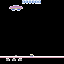

In [ ]:
# 画像をGIFに変換
def create_gif(frames, gif_path):
    # 画像のパスを取得

    # 画像を開く
    images = [Image.fromarray((img * 255).astype('uint8')).convert('RGB') for img in frames]

    # GIFを作成
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=1500,  # フレームの表示時間 (ミリ秒)
        loop=0  # 0は無限ループ
    )

# 画像が保存されているフォルダのパスと保存するGIFのパスを指定
gif_path = "/content/result_v2.gif"

# GIFを作成
create_gif(frames, gif_path)

# GIFを再生
from IPython.display import Image as IPImage
IPImage(filename=gif_path)

In [ ]:
len(frames)

217

In [ ]:
best_action

tensor([19], device='cuda:0')

In [ ]:
action_int

19

In [ ]:
from PIL import Image, ImageDraw, ImageFont

def create_text_image(text, image_width, image_height, font_path="arial.ttf"):
    # 画像を作成
    image = Image.new("RGB", (image_width, image_height), color="white")
    draw = ImageDraw.Draw(image)

    # フォントを設定
    # font = ImageFont.truetype(font_path, 20)

    # テキストを画像の中央に配置
    text_bbox = draw.textbbox((0, 0), text)  # textbboxを使用
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    text_x = (image_width - text_width) // 2
    text_y = (image_height - text_height) // 2

    # テキストを描画
    draw.text((text_x, text_y), text, fill="black")

    return image


image = create_text_image(str(discriptions[0]), 128, 128)

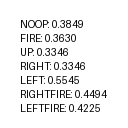

In [ ]:
image

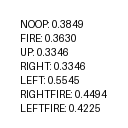

In [ ]:
# 画像をGIFに変換
def create_gif(discriptions, gif_path):
    # 画像のパスを取得

    # 画像を開く
    images = [create_text_image(discription, 128, 128) for discription in discriptions]

    # GIFを作成
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=1500,  # フレームの表示時間 (ミリ秒)
        loop=0  # 0は無限ループ
    )

# 画像が保存されているフォルダのパスと保存するGIFのパスを指定
gif_path = "/content/result_text_v2.gif"

# GIFを作成
create_gif(discriptions, gif_path)

# GIFを再生
from IPython.display import Image as IPImage
IPImage(filename=gif_path)